# (outlined) North Atlantic Hurricanes
The learning objectives of this notebook are to carry out feature selection for a classification model, train a classification model for types of hurricanes, and understand outcomes of feature uncertainty based on a experiment.

The [North Atlantic Hurricanes dataset](https://myweb.fsu.edu/jelsner/temp/Data.html) used is developed by James B. Elsner and colleagues containing hurricanes recorded during the years 1944 to 2000. Each hurricane instance contains the year, the name (if it was named), the coordinates where it started, the last coordinates measured, the maximum coordinates (based on an aspect that an increment means closer to the coast), the maximum intensity, and the type. They are labeled into 3 types: tropical hurricanes (Type 0), hurricanes under baroclinic influences (Type 1), and hurricanes from baroclinic initiation (Type 3).

Let's start with loading the data.

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_FOLDER = Path("..") / "data"
DATA_FILEPATH = DATA_FOLDER / "hurricanes.csv"
# Execute on cloud platform? (e.g. colab), try this path instead
# DATA_FILEPATH = "https://raw.githubusercontent.com/jeepchinnawat/edumat-book/main/data/hurricanes.csv"

hurricanes = pd.read_csv(DATA_FILEPATH)
hurricanes

,RowNames,Number,Name,Year,Type,FirstLat,FirstLon,MaxLat,MaxLon,LastLat,LastLon,MaxInt
0,1,430,NOTNAMED,1944,1,30.2,-76.1,32.1,-74.8,35.1,-69.2,80
1,2,432,NOTNAMED,1944,0,25.6,-74.9,31.0,-78.1,32.6,-78.2,80
2,3,433,NOTNAMED,1944,0,14.2,-65.2,16.6,-72.2,20.6,-88.5,105
3,4,436,NOTNAMED,1944,0,20.8,-58.0,26.3,-72.3,42.1,-71.5,120
4,5,437,NOTNAMED,1944,0,20.0,-84.2,20.6,-84.9,19.1,-93.9,70
...,...,...,...,...,...,...,...,...,...,...,...,...
332,333,1227,GORDON,2000,1,25.2,-85.4,26.1,-84.9,28.0,-83.8,70
333,334,1229,ISAAC,2000,0,14.3,-33.2,26.6,-54.2,39.7,-47.9,120
334,335,1230,JOYCE,2000,0,12.4,-38.8,12.2,-42.5,10.5,-48.6,80
335,336,1231,KEITH,2000,0,17.9,-86.4,17.9,-87.2,22.6,-97.9,120


## Introductory Data Inspection

In [2]:
hurricanes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337 entries, 0 to 336
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   RowNames  337 non-null    int64  
 1   Number    337 non-null    int64  
 2   Name      337 non-null    object 
 3   Year      337 non-null    int64  
 4   Type      337 non-null    int64  
 5   FirstLat  337 non-null    float64
 6   FirstLon  337 non-null    float64
 7   MaxLat    337 non-null    float64
 8   MaxLon    337 non-null    float64
 9   LastLat   337 non-null    float64
 10  LastLon   337 non-null    float64
 11  MaxInt    337 non-null    int64  
dtypes: float64(6), int64(5), object(1)
memory usage: 31.7+ KB


We will leave out the year and go on with first, last, and maximum cooridinates and maximum intensity as our potential fields for classification task.

In [3]:
features = ['FirstLat','FirstLon','MaxLat','MaxLon','LastLat','LastLon','MaxInt']
label = ['Type']

We can look at simple statistics of our features with `describe` function of pandas' dataframe.

In [4]:
hurricanes[features].describe()

,FirstLat,FirstLon,MaxLat,MaxLon,LastLat,LastLon,MaxInt
count,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000
mean,23.437982,-65.568546,27.198220,-68.650742,34.550148,-64.895252,94.572700
std,7.592829,17.665280,7.724416,16.875719,10.175473,22.074126,23.287442
min,10.300000,-96.700000,10.300000,-98.400000,10.000000,-99.200000,65.000000
25%,16.600000,-80.000000,21.700000,-82.500000,28.700000,-83.500000,75.000000
50%,23.300000,-65.300000,27.300000,-68.400000,35.500000,-65.600000,90.000000
75%,28.700000,-53.400000,33.000000,-56.800000,42.100000,-48.500000,110.000000
max,46.000000,-23.000000,48.000000,-7.500000,61.100000,-5.000000,165.000000


Simply replacing `describe` with `boxplot`, we can visualize some of stats above with box plot.

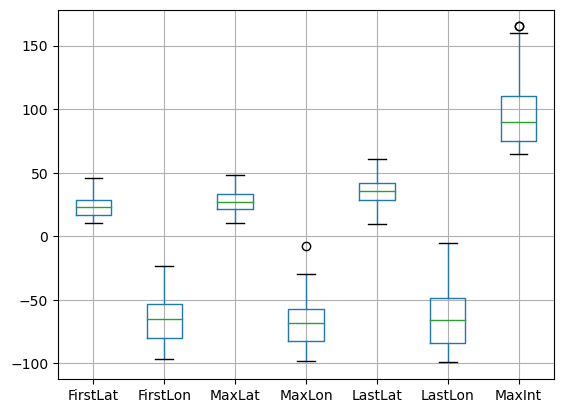

In [5]:
hurricanes[features].boxplot()
plt.show()

## Feature Selection

### Univariate Selection

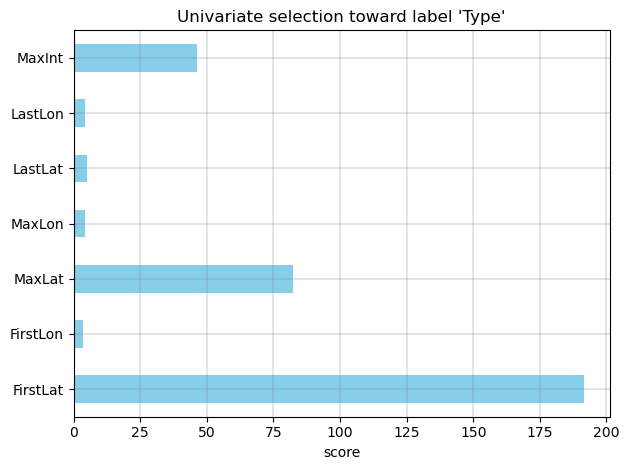

In [6]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k=2)
selector.fit(hurricanes[features], hurricanes[label[0]])
scores = selector.scores_

features_scores = pd.Series(scores, index=features)

fig, ax = plt.subplots()
features_scores.plot.barh(ax=ax, color='skyblue')
ax.grid(True, which='both', color='grey', linewidth=0.3)
ax.set_title("Univariate selection toward label 'Type'")
ax.set_xlabel("score")
fig.tight_layout()
plt.show()

### Random Forest's Feature Importance

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Parameters for GridSearch
param_grid = {
'n_estimators': [10, 20, 30, 40],
'max_depth': [2,4,6, 8],
'min_samples_split': [2, 4],
    'max_features': [1,2,4,7]
}

# rf = RandomForestClassifier(random_state=20, n_jobs=2,min_samples_leaf=1)
# # Grid search with cross-validation
# cv_rf = GridSearchCV(estimator=rf, param_grid=param_grid)
# cv_rf.fit(X_train, y_train)
# print(f"Best parameters: {cv_rf.best_params_}")

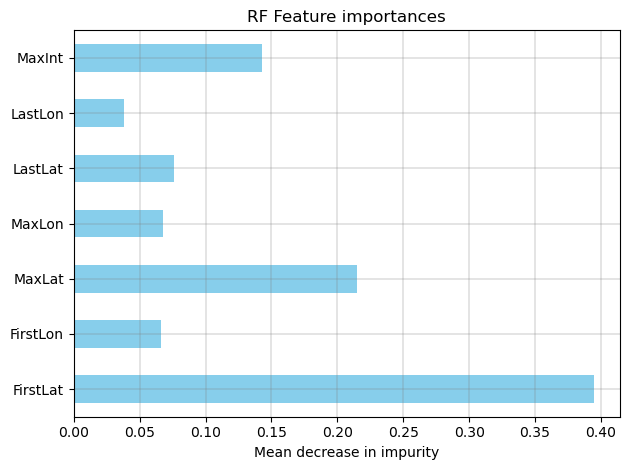

In [8]:
rf = RandomForestClassifier(random_state=0, n_jobs=2, min_samples_leaf=1,
                            max_depth=4, max_features=2, min_samples_split=2, n_estimators=40)
rf.fit(hurricanes[features], hurricanes[label[0]])

importances = rf.feature_importances_
features_scores = pd.Series(importances, index=features)

fig, ax = plt.subplots()
features_scores.plot.barh(ax=ax, color='skyblue')
ax.grid(True, which='both', color='grey', linewidth=0.3)
ax.set_title("RF Feature importances")
ax.set_xlabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

In [9]:
selected_features = ['FirstLat', 'MaxLat', 'MaxInt']

## Why not FirstLat,MaxLat together?

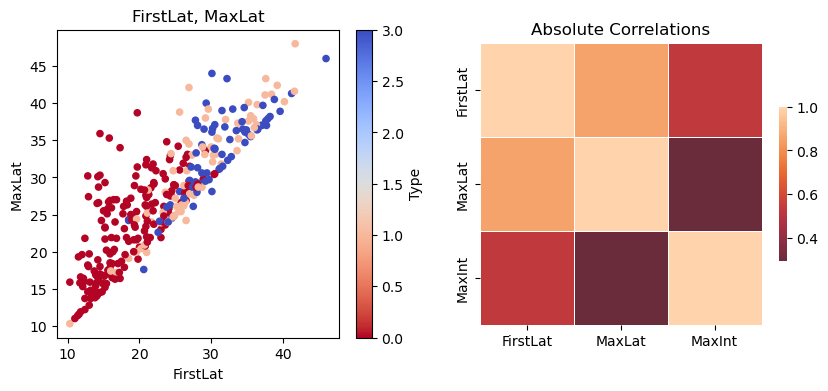

In [10]:
import seaborn as sns

fig, axs = plt.subplots(1,2, figsize=(10, 4))

hurricanes.plot.scatter('FirstLat', 'MaxLat', c='Type', colormap='coolwarm_r', ax=axs[0])
axs[0].set_title("FirstLat, MaxLat")

# the abs. correlation matrix
df = pd.DataFrame(hurricanes, columns=selected_features)
abs_corr = df.corr().abs()
sns.heatmap(abs_corr, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=axs[1])
axs[1].set_title("Absolute Correlations")

plt.show()

In [11]:
selected_features = ['FirstLat', 'MaxInt']

## Stratified Data Splitting

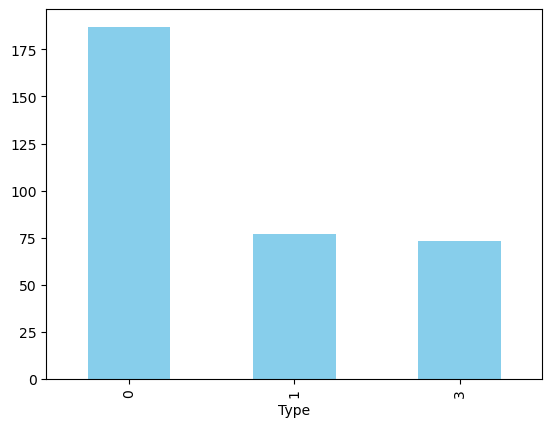

In [12]:
hurricanes.groupby('Type').Type.count().plot(kind='bar', color='skyblue')
plt.show()

In [13]:
from sklearn.model_selection import train_test_split

X,y = hurricanes[selected_features].copy(), hurricanes[label[0]].copy()
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, train_size=.7, random_state=0, stratify=y)

## Classification Model

In [14]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

svm = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('svc', SVC())
])

svm.fit(X_train, y_train)
svm.score(X_train, y_train)

0.723404255319149

In [15]:
svm.score(X_test, y_test)

0.696078431372549

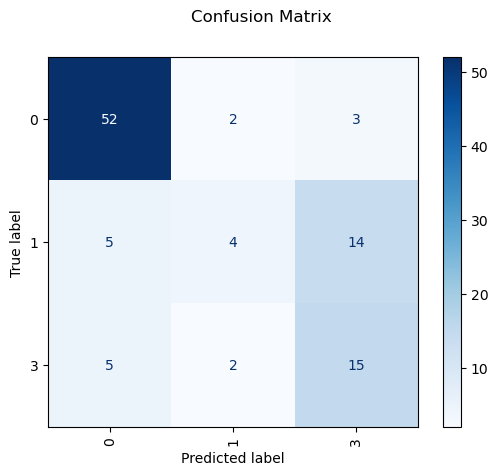

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

y_pred = svm.predict(X_test)

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation = 'vertical',
                                               cmap=plt.cm.Blues)
disp.figure_.suptitle("Confusion Matrix")

plt.show()

### Transform to binary classification

In [17]:
tropical = hurricanes.copy()

# merge type 3 into type 1 for binary classification problem (tropical hurricane or not?)
tropical.loc[tropical['Type'] == 3, 'Type'] = 1
# check for binary type
tropical['Type'].unique()

array([1, 0])

In [18]:
X,y = tropical[selected_features].copy(), tropical[label[0]].copy()
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, train_size=.7, random_state=0, stratify=y)

In [19]:
import matplotlib.patches

def plot_2DClassifier(X, f, y, classifier, title):
    # create a predicted mesh
    s = 0.2
    f1, f2 = f[0], f[1]
    x_min, x_max = X[f1].min() - 1, X[f1].max() + 1
    y_min, y_max = X[f2].min() - 1, X[f2].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, s), np.arange(y_min, y_max, s))
    df = {f1: xx.ravel(),f2: yy.ravel()}
    xy = pd.DataFrame(df)
    Z = classifier.predict(xy)
    fig, ax = plt.subplots()
    
    # Fill the plot with predicted mesh
    levels, categories = pd.factorize(Z, sort=True)
    levels = levels.reshape(xx.shape)
    ax.contourf(xx, yy, levels, cmap=plt.cm.coolwarm, alpha=0.3)

    # data scatter plot
    n_classes = classifier.classes_.shape[0]
    levels, categories = pd.factorize(y, sort=True)
    handles = [matplotlib.patches.Patch(color=plt.cm.coolwarm.resampled(n_classes)(i), label=c) for i, c in enumerate(categories)]
    ax.scatter(X[f1], X[f2], c=levels, cmap=plt.cm.coolwarm, edgecolors='black')
    ax.set_xlabel(f1)
    ax.set_ylabel(f2)
    ax.set_title(title)
    ax.legend(handles=handles)
    plt.show()

### SVM's hyperparameters (interactive w/ ipywidgets)

In [20]:
from ipywidgets import interact, fixed
import ipywidgets as widgets

def svc_interact(C, gamma, model):
    status_widget.value = 'Calculating...'
    
    model.named_steps.svc.set_params(**{'C': C, 'gamma': gamma})

    model.fit(X_train, y_train)
    plot_2DClassifier(X_train, selected_features, y_train, model, "SVM w/ training set")
    
    status_widget.value = f'Test set accuracy : {model.score(X_test, y_test)}'

C_widget = widgets.FloatLogSlider(value=10., min=-3, max=2, base=10, step=0.2, description='C:', disabled=False, continuous_update=False, orientation='horizontal', readout=True, readout_format='.3f')
gamma_widget = widgets.FloatLogSlider(value=0.25, min=-3, max=2, base=10, step=0.2, description='Gamma:', disabled=False, continuous_update=False, orientation='horizontal', readout=True, readout_format='.3f')
status_widget = widgets.Label(value='')

bi_svm = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('svc', SVC())
])

interact(svc_interact, C=C_widget, gamma=gamma_widget, model=fixed(bi_svm))
display(status_widget)

interactive(children=(FloatLogSlider(value=10.0, continuous_update=False, description='C:', max=2.0, min=-3.0,…

Label(value='Test set accuracy : 0.8235294117647058')

## Feature uncertainty experiment
- Assume above the decision boundary(model) as a model a data annotator uses to label trocical hurricanes
- features X also as true measurements
- Re-classify X with the model to have truely annotated labels (wrt. an annotator)

(Re-classify the features with the model to have a perfectly separable dataset and then add Gaussian noise the the features to see the outcome.)

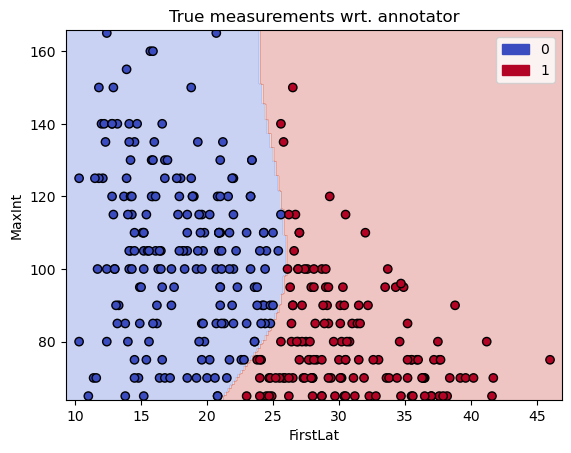

In [21]:
true_y = bi_svm.predict(X)

plot_2DClassifier(X, selected_features, true_y, bi_svm, "True measurements wrt. annotator")

### Add Gaussian noise to features
(Expected: Affecting data points in the vicinity of decision boundaries)

In [22]:
def noise_interact(sd):
    status_widget.value = 'Calculating...'
    noisy_X = X + np.random.normal(loc=0.0, scale=sd, size=X.shape)
    
    plot_2DClassifier(noisy_X, selected_features, true_y, bi_svm, "Noisy measurement wrt. annotator")

    noisy_pred = bi_svm.predict(noisy_X)
    status_widget.value = f"Noisy inputs accuracy: {bi_svm.score(noisy_X, true_y)}"

sd_widget = widgets.FloatSlider(value=1., min=0.1, max=5., step=0.1, description='SD :',
    disabled=False, continuous_update=False, orientation='horizontal', readout=True, readout_format='.1f'
)
status_widget = widgets.Label(value='')

interact(noise_interact, sd=sd_widget)
display(status_widget)

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='SD :', max=5.0, min=0.1, re…

Label(value='Noisy inputs accuracy: 0.9762611275964391')